In [ ]:
import numpy as np
import torch
import torch.nn               as nn
import torch.distributions as tdist
import os
import sys
from torch.utils.data import Dataset, TensorDataset, DataLoader
import torch.optim as optim
import torch.nn.utils.spectral_norm as spectral_norm
from torch.utils.data         import Dataset, TensorDataset, DataLoader
from torchvision              import datasets
import time
from time import sleep
from tqdm import tqdm
from prettytable import PrettyTable

from google.colab import drive
drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/NashFPNs/TransportationNetworks/')
save_dir = './drive/MyDrive/NashFPNs/'

device = "cuda"

capacity   = torch.tensor
context    = torch.tensor
action     = torch.tensor
edge       = torch.tensor
inference  = torch.tensor 
context    = torch.tensor

seed = 42
torch.manual_seed(seed)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Training Data

In [ ]:
data_set = 'Anaheim'
save_dir = 'drive/MyDrive/NashFPNs/TrafficTrainingData/'
state_path = save_dir + data_set + '_training_data.pth'
state = torch.load(state_path)

In [ ]:
capacity        = state['capacity']
W               = state['W']
N               = state['N']
free_flow_time  = state['free_flow_time']
x_train         = state['x_train']
x_test          = state['x_test']
d_train         = state['d_train']
d_test          = state['d_test']
b               = state['origin_destination_pairs']

context_size    = d_train.shape[1]
n_train         = d_train.shape[0]
n_test          = d_test.shape[0]

n_ODpairs       = b.shape[1]
n_edges         = x_train.shape[1]
n_nodes         = b.shape[0]

In [ ]:
train_dataset   = TensorDataset(x_train, d_train)
test_dataset    = TensorDataset(x_test, d_test)

train_batch_size = 100
test_batch_size  = 100

train_loader  = DataLoader(dataset=train_dataset,  
                            batch_size=train_batch_size, shuffle=True) 
test_loader   = DataLoader(dataset=test_dataset,   
                            batch_size=test_batch_size,  shuffle=False) 

In [ ]:
print('n_ODpairs = ', n_ODpairs, 'n_nodes = ', n_nodes, ', n_edges = ', n_edges, ', n_train = ', x_train.shape[0])

n_ODpairs =  1406 n_nodes =  416 , n_edges =  914 , n_train =  5000


## Create Neural Network Architecture

In [ ]:
inference = torch.tensor
latent_variable = torch.tensor
context = torch.tensor

class Traffix_Net(nn.Module):
    def __init__(self, N, b, context_size, alpha, device):
        super().__init__()
        
        self.b = b.to(device)
        self.alpha = alpha

        U,s,VT = torch.linalg.svd(N, full_matrices=False) 
        # truncate sing. values below 1e-5
        ind = s >= 1e-5 
        s = s[ind]
        U = U[:,ind]
        VT = VT[ind, :]
        self.V = VT.t().to(device)
        self.V_Sinv_UT = VT.t().matmul( torch.diag(1/s).matmul(U.t()) ).to(device)

        self.n_nodes    = N.shape[0]
        self.n_edges    = N.shape[1] 
        self.n_ODpairs  = b.shape[1] 

        self.F_fcs_d = nn.ModuleList([nn.Linear(context_size, 100), 
                                    nn.Linear(100, 100),
                                    nn.Linear(100, 100)])
        self.fc_final_d = nn.Linear(100, self.n_edges)

        self.F_fcs = nn.ModuleList([nn.Linear(self.n_edges, 100), 
                                    nn.Linear(100, 100)])
        self.fc_final = nn.Linear(100, self.n_edges)
        self.relu = nn.ReLU()
        self.leaky_relu = nn.LeakyReLU(0.1)

        self.tanh = nn.Tanh()

        for fc in self.F_fcs: 
          torch.nn.init.zeros_(fc.weight)
        for fc in self.F_fcs_d: 
          torch.nn.init.zeros_(fc.weight)

        torch.nn.init.zeros_(self.fc_final.weight)
        torch.nn.init.zeros_(self.fc_final_d.weight)

    def device(self):
        return next(self.parameters()).data.device

    def project_C1(self, z: latent_variable) -> latent_variable: 
        return torch.clamp(z, min=0)

    def project_C2(self, z: latent_variable) -> latent_variable:
        Pz    = z - (self.V).matmul(self.V.t().matmul(z)) + self.V_Sinv_UT.matmul(self.b.unsqueeze(0))
        return Pz

    def F(self, x: action, d: context) -> action: 
      """
        Game Gradient Parameterization
          Inputs: 
            x = action with shape (batch_size x n_edges) 
            d = context with shape (batch_size x context_size)
      """

        Fd = d
        for fc in self.F_fcs_d:
          Fd = self.tanh(fc(Fd))
        Fd = self.leaky_relu(self.fc_final_d(Fd))
        
        Fx = x
        for fc in self.F_fcs: 
            Fx = self.tanh(fc(Fx)) 

        Fx = self.leaky_relu(self.fc_final(Fx))
        Fx = torch.clamp(Fx, min = -5e6, max=5e6) 
        
        return self.leaky_relu(Fx*Fd)
        

    def T(self, z: latent_variable, d: context) -> latent_variable: 
      """
        Davis-Yin Splitting described in Algorithm 3 
          Inputs: 
            z = action with shape (batch_size x n_edges x n_ODpairs) 
            d = context with shape (batch_size x context_size)
      """

        x = self.project_C1(z)
        v = torch.sum(x, dim=2)
        Fv = self.F(v,d)
        y = 2*x - z - self.alpha*Fv.unsqueeze(2)
        y = self.project_C2(y)
        z = z + y - x

        return z


    def S(self, z: latent_variable) -> inference:
      """
        Final layer that map from latent space to inference space. 
        Operations: project, sum across OD pairs, and clamp
          Inputs: 
            z = action with shape (batch_size x n_edges x n_ODpairs) 
          Output:
            v = action with shape (batch_size x n_edges)
      """

        z = self.project_C1(z)
        v = torch.sum(z, dim=2)
        return torch.clamp(v, max=1e6)

    def forward(self, d: context, eps=1.0e-2, max_depth=100, 
                depth_warning=False) -> inference: 

        with torch.no_grad():
            self.depth = 0.0

            z = torch.zeros((d.shape[0], self.n_edges, self.n_ODpairs), device=self.device())
            z_prev = z.clone()         
            
            all_samp_conv = False
            while not all_samp_conv and self.depth < max_depth:
                z_prev = z.clone()   
                z = self.T(z,d)
                diff_norm = torch.norm(z - z_prev, dim=1) 
                diff_norm = torch.norm( diff_norm, dim=1) 
                diff_norm = torch.max( diff_norm ) # take norm along the latter two dimensions then max
                self.depth += 1.0
                all_samp_conv = diff_norm <= eps
            
        if self.depth >= max_depth and depth_warning:
            print("\nWarning: Max Depth Reached - Break Forward Loop\n")

        attach_gradients = self.training
        if attach_gradients:
            z = self.T(z, d)
            return self.S(z)
        else:
            return self.S(z) 


  

In [ ]:
alpha = 1e-2
net = Traffix_Net(N, b, context_size, alpha, device)
net.to(device)

tensor([[ 9956.8223, 13164.6855, 10436.3770,  ...,  1951.9572,   626.5675,
          1761.3159],
        [ 9956.8223, 13164.6855, 10436.3770,  ...,  1951.9572,   626.5675,
          1761.3159],
        [ 9956.8223, 13164.6855, 10436.3770,  ...,  1951.9572,   626.5675,
          1761.3159],
        ...,
        [ 9956.8223, 13164.6855, 10436.3770,  ...,  1951.9572,   626.5675,
          1761.3159],
        [ 9956.8223, 13164.6855, 10436.3770,  ...,  1951.9572,   626.5675,
          1761.3159],
        [ 9956.8223, 13164.6855, 10436.3770,  ...,  1951.9572,   626.5675,
          1761.3159]], device='cuda:0', grad_fn=<ClampBackward>)

In [ ]:
def get_trafix_score(x_pred: action, x_true: action, eps=5.0e-3, 
                     tol=1.0e-3) -> float:
  err           = torch.abs(x_pred - x_true)
  denom         = torch.abs(x_true) + tol
  rel_err       = err.div(denom)
  acc_preds     = rel_err < eps  
  num_samples   = x_true.shape[0]
  num_preds     = x_true.shape[1]
  trafix_score  = 100.0 * sum(sum(acc_preds)) / (num_samples * num_preds) 
  return trafix_score

def get_testing_stats(net, test_loader, criterion, n_edges, eps, depth, eps_traffix_score, device=device):
    test_loss = 0
    correct = 0
    rel_err = 0
    rel_err_dim0 = torch.zeros(n_edges, device=device)

    net.eval()
    with torch.no_grad():
        for _, (x_true, d_true) in enumerate(test_loader):
          
          x_true, d_true = x_true.to(device), d_true.to(device)
          batch_size = x_true.shape[0]

          x_pred = net(d_true, eps=eps, max_depth=depth) 

          test_loss += batch_size * criterion(x_pred, x_true)

          rel_err += torch.norm(x_pred - x_true)**2
          rel_err_dim0 += torch.norm(x_pred - x_true, dim=0)**2

    test_loss  /= len(test_loader.dataset)
    rel_err    = torch.sqrt(rel_err) / norm_x_test

    traffix_score = get_trafix_score(x_pred, x_true, eps=eps_traffix_score) 
    

    net.train()

    return test_loss, rel_err, traffix_score


In [ ]:
def model_params(net):
    table = PrettyTable(["Network Component", "# Parameters"])
    num_params = 0
    for name, parameter in net.named_parameters():
        if not parameter.requires_grad:
            continue
        table.add_row([name, parameter.numel()])
        num_params += parameter.numel()
    table.add_row(['TOTAL', num_params])
    return table

print(net)
print(model_params(net))

Traffix_Net(
  (F_fcs_d): ModuleList(
    (0): Linear(in_features=10, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
  )
  (fc_final_d): Linear(in_features=100, out_features=914, bias=True)
  (F_fcs): ModuleList(
    (0): Linear(in_features=914, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
  )
  (fc_final): Linear(in_features=100, out_features=914, bias=True)
  (relu): ReLU()
  (leaky_relu): LeakyReLU(negative_slope=0.1)
  (tanh): Tanh()
)
+-------------------+--------------+
| Network Component | # Parameters |
+-------------------+--------------+
|  F_fcs_d.0.weight |     1000     |
|   F_fcs_d.0.bias  |     100      |
|  F_fcs_d.1.weight |    10000     |
|   F_fcs_d.1.bias  |     100      |
|  F_fcs_d.2.weight |    10000     |
|   F_fcs_d.2.bias  |     100      |
| fc_final_d.weight |    91400     |
|  fc_final_d.bias  |     914     

## Set up Training

In [ ]:
# training setup
learning_rate = 1e-3
optimizer     = optim.Adam(net.parameters(), lr=learning_rate)
lr_scheduler  = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
eps           = 1.0e-4  # Used for stopping criterion in implicit-depth
criterion     = nn.MSELoss()
max_depth     = 50

train_loss_hist     = []
test_loss_hist      = []
traffix_score_hist  = []
rel_err_hist        = []
best_traffix_score  = 0.0

max_epochs = int(2e2)
x_test = x_test.to(device)
d_test = d_test.to(device)

# start_time_epoch = time.time() # timer for display execution time per epoch multiple
fmt        = '[{:4d}/{:4d}]: train loss = {:7.3e} | test loss = {:7.3e} | TRAFFIX score = {:7.3f}% | rel error = {:7.3e} ' 
fmt       += 'depth = {:5.1f} | lr = {:5.1e} | eps = {:5.1e} | time = {:5.1e}'
print(net)                 # display Tnet configuration
 
print('\nTraining G-FPN')
for epoch in range(max_epochs): 

  net.train()
  sleep(0.3)  # slows progress bar so it won't print on multiple lines
  loss_ave        = 0.0
  epoch_start_time = time.time()
  tot = len(train_loader)
  with tqdm(total=tot, unit=" batch", leave=False, ascii=True) as tepoch:

    tepoch.set_description("[{:3d}/{:3d}]".format(epoch+1, max_epochs))

    for _, (x_true, d_true) in enumerate(train_loader):

      x_true, d_true = x_true.to(device), d_true.to(device)

      optimizer.zero_grad()
      x_pred = net(d_true, eps=eps, max_depth=max_depth) 

      loss = criterion(x_pred, x_true)
      local_batch_size = x_true.shape[0]
      loss_ave += local_batch_size * loss

      loss.backward()
      optimizer.step()

      tepoch.update(1)
      tepoch.set_postfix(train_loss="{:5.2e}".format(loss.detach().cpu().numpy()),
                          depth="{:5.1f}".format(net.depth))

  lr_scheduler.step()
  epoch_end_time = time.time()
  time_epoch = epoch_end_time - epoch_start_time
  loss_ave = loss_ave/n_train
  train_loss_hist.append(loss_ave)

  eps_traffix_score = 5e-3
  test_loss, rel_err_test, traffix_score = get_testing_stats(net, test_loader, criterion, n_edges, eps, max_depth, eps_traffix_score)

  traffix_score_hist.append(traffix_score)
  test_loss_hist.append(test_loss)
  rel_err_hist.append(rel_err_test)

 
  print(fmt.format(epoch+1, max_epochs, loss.item(), test_loss, traffix_score, rel_err_test, net.depth, 
                    optimizer.param_groups[0]['lr'], eps, time_epoch))
  
  # ---------------------------------------------------------------------
  # Save weights
  # ---------------------------------------------------------------------
  if traffix_score > best_traffix_score:
    best_traffix_score = traffix_score
    state = {
        'test_loss_hist': test_loss_hist,
        'traffix_score_hist': traffix_score_hist,
        'rel_err_hist': rel_err_hist,
        'net_state_dict': net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'lr_scheduler': lr_scheduler,
    }
    file_name = save_dir + 'FinalResults/' + data_set + '_weights.pth'
    torch.save(state, file_name)
    print('Model weights saved to ' + file_name)

  # ---------------------------------------------------------------------
  # Save history at last epoch
  # ---------------------------------------------------------------------

  if epoch+1 == max_epochs:
      state = {
        'test_loss_hist': test_loss_hist,
        'traffix_score_hist': traffix_score_hist,
        'rel_err_hist': rel_err_hist,
        'lr_scheduler': lr_scheduler,
        'eps': eps,
      }
      file_name = save_dir + 'FinalResults/' + data_set + '_history.pth'
      torch.save(state, file_name)
      print('Training history saved to ' + file_name)

Traffix_Net(
  (F_fcs_d): ModuleList(
    (0): Linear(in_features=10, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
  )
  (fc_final_d): Linear(in_features=100, out_features=914, bias=True)
  (F_fcs): ModuleList(
    (0): Linear(in_features=914, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
  )
  (fc_final): Linear(in_features=100, out_features=914, bias=True)
  (relu): ReLU()
  (leaky_relu): LeakyReLU(negative_slope=0.1)
  (tanh): Tanh()
)

Training G-FPN


[   1/ 200]: train loss = 3.769e+03 | test loss = 3.696e+03 | TRAFFIX score =  58.548% | rel error = 1.506e-02 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[   2/ 200]: train loss = 2.870e+03 | test loss = 2.922e+03 | TRAFFIX score =  59.756% | rel error = 1.339e-02 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[   3/ 200]: train loss = 2.967e+03 | test loss = 2.919e+03 | TRAFFIX score =  59.873% | rel error = 1.338e-02 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[   4/ 200]: train loss = 3.199e+03 | test loss = 2.924e+03 | TRAFFIX score =  58.882% | rel error = 1.340e-02 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02


[   5/ 200]: train loss = 1.366e+03 | test loss = 1.362e+03 | TRAFFIX score =  72.106% | rel error = 9.141e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[   6/ 200]: train loss = 1.606e+03 | test loss = 1.372e+03 | TRAFFIX score =  71.572% | rel error = 9.174e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02


[   7/ 200]: train loss = 1.476e+03 | test loss = 1.317e+03 | TRAFFIX score =  72.931% | rel error = 8.990e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[   8/ 200]: train loss = 1.171e+03 | test loss = 1.140e+03 | TRAFFIX score =  76.123% | rel error = 8.365e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[   9/ 200]: train loss = 1.212e+03 | test loss = 1.091e+03 | TRAFFIX score =  77.319% | rel error = 8.181e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[  10/ 200]: train loss = 1.144e+03 | test loss = 1.062e+03 | TRAFFIX score =  77.992% | rel error = 8.071e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[  11/ 200]: train loss = 1.074e+03 | test loss = 1.083e+03 | TRAFFIX score =  77.973% | rel error = 8.151e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02


[  12/ 200]: train loss = 9.684e+02 | test loss = 1.096e+03 | TRAFFIX score =  78.613% | rel error = 8.200e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[  13/ 200]: train loss = 9.832e+02 | test loss = 9.713e+02 | TRAFFIX score =  78.386% | rel error = 7.720e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02


[  14/ 200]: train loss = 9.631e+02 | test loss = 9.066e+02 | TRAFFIX score =  78.976% | rel error = 7.458e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[  15/ 200]: train loss = 9.610e+02 | test loss = 8.611e+02 | TRAFFIX score =  79.441% | rel error = 7.269e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[  16/ 200]: train loss = 8.394e+02 | test loss = 7.597e+02 | TRAFFIX score =  80.198% | rel error = 6.827e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[  17/ 200]: train loss = 6.241e+02 | test loss = 6.584e+02 | TRAFFIX score =  81.848% | rel error = 6.356e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[  18/ 200]: train loss = 4.768e+02 | test loss = 5.435e+02 | TRAFFIX score =  84.425% | rel error = 5.775e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[  19/ 200]: train loss = 4.016e+02 | test loss = 4.025e+02 | TRAFFIX score =  87.155% | rel error = 4.970e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[  20/ 200]: train loss = 3.298e+02 | test loss = 3.471e+02 | TRAFFIX score =  88.380% | rel error = 4.615e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[  21/ 200]: train loss = 3.237e+02 | test loss = 3.195e+02 | TRAFFIX score =  89.127% | rel error = 4.428e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[  22/ 200]: train loss = 2.924e+02 | test loss = 2.946e+02 | TRAFFIX score =  89.850% | rel error = 4.252e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[  23/ 200]: train loss = 2.757e+02 | test loss = 2.741e+02 | TRAFFIX score =  90.297% | rel error = 4.101e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[  24/ 200]: train loss = 3.064e+02 | test loss = 2.758e+02 | TRAFFIX score =  90.771% | rel error = 4.114e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[  25/ 200]: train loss = 2.591e+02 | test loss = 2.401e+02 | TRAFFIX score =  90.960% | rel error = 3.838e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[  26/ 200]: train loss = 2.549e+02 | test loss = 2.261e+02 | TRAFFIX score =  91.165% | rel error = 3.725e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[  27/ 200]: train loss = 2.421e+02 | test loss = 2.480e+02 | TRAFFIX score =  90.918% | rel error = 3.901e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02


[  28/ 200]: train loss = 2.012e+02 | test loss = 2.174e+02 | TRAFFIX score =  91.284% | rel error = 3.653e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[  29/ 200]: train loss = 1.652e+02 | test loss = 2.024e+02 | TRAFFIX score =  91.636% | rel error = 3.524e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[  30/ 200]: train loss = 1.865e+02 | test loss = 1.986e+02 | TRAFFIX score =  91.938% | rel error = 3.491e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[  31/ 200]: train loss = 2.100e+02 | test loss = 1.983e+02 | TRAFFIX score =  91.788% | rel error = 3.489e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02


[  32/ 200]: train loss = 1.985e+02 | test loss = 2.006e+02 | TRAFFIX score =  92.077% | rel error = 3.508e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[  33/ 200]: train loss = 1.550e+02 | test loss = 1.839e+02 | TRAFFIX score =  92.176% | rel error = 3.359e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[  34/ 200]: train loss = 1.489e+02 | test loss = 2.072e+02 | TRAFFIX score =  92.240% | rel error = 3.565e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[  35/ 200]: train loss = 1.661e+02 | test loss = 1.888e+02 | TRAFFIX score =  92.295% | rel error = 3.403e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[  36/ 200]: train loss = 1.880e+02 | test loss = 1.833e+02 | TRAFFIX score =  92.360% | rel error = 3.354e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[  37/ 200]: train loss = 1.736e+02 | test loss = 1.839e+02 | TRAFFIX score =  92.454% | rel error = 3.359e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[  38/ 200]: train loss = 1.767e+02 | test loss = 2.024e+02 | TRAFFIX score =  92.807% | rel error = 3.524e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[  39/ 200]: train loss = 1.676e+02 | test loss = 1.845e+02 | TRAFFIX score =  92.546% | rel error = 3.365e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02


[  40/ 200]: train loss = 1.712e+02 | test loss = 1.805e+02 | TRAFFIX score =  92.545% | rel error = 3.328e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02


[  41/ 200]: train loss = 1.271e+02 | test loss = 1.860e+02 | TRAFFIX score =  92.775% | rel error = 3.378e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02


[  42/ 200]: train loss = 1.476e+02 | test loss = 1.909e+02 | TRAFFIX score =  92.508% | rel error = 3.422e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02


[  43/ 200]: train loss = 1.498e+02 | test loss = 1.672e+02 | TRAFFIX score =  92.659% | rel error = 3.203e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02


[  44/ 200]: train loss = 2.879e+02 | test loss = 1.883e+02 | TRAFFIX score =  92.685% | rel error = 3.399e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02


[  45/ 200]: train loss = 1.516e+02 | test loss = 1.799e+02 | TRAFFIX score =  92.694% | rel error = 3.322e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02


[  46/ 200]: train loss = 1.964e+02 | test loss = 1.741e+02 | TRAFFIX score =  93.049% | rel error = 3.268e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[  47/ 200]: train loss = 2.078e+02 | test loss = 1.666e+02 | TRAFFIX score =  92.883% | rel error = 3.197e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02


[  48/ 200]: train loss = 1.224e+02 | test loss = 1.654e+02 | TRAFFIX score =  92.998% | rel error = 3.185e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02


[  49/ 200]: train loss = 1.432e+02 | test loss = 2.299e+02 | TRAFFIX score =  92.766% | rel error = 3.756e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02


[  50/ 200]: train loss = 2.398e+02 | test loss = 2.450e+02 | TRAFFIX score =  91.973% | rel error = 3.877e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02


[  51/ 200]: train loss = 1.561e+02 | test loss = 1.673e+02 | TRAFFIX score =  92.851% | rel error = 3.204e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02


[  52/ 200]: train loss = 1.392e+02 | test loss = 1.644e+02 | TRAFFIX score =  93.092% | rel error = 3.176e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[  53/ 200]: train loss = 1.745e+02 | test loss = 1.679e+02 | TRAFFIX score =  93.107% | rel error = 3.210e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[  54/ 200]: train loss = 2.272e+02 | test loss = 1.968e+02 | TRAFFIX score =  93.300% | rel error = 3.475e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[  55/ 200]: train loss = 1.364e+02 | test loss = 1.565e+02 | TRAFFIX score =  93.209% | rel error = 3.099e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02


[  56/ 200]: train loss = 1.717e+02 | test loss = 1.595e+02 | TRAFFIX score =  93.237% | rel error = 3.128e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02


[  57/ 200]: train loss = 1.590e+02 | test loss = 1.640e+02 | TRAFFIX score =  93.208% | rel error = 3.172e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02


[  58/ 200]: train loss = 1.831e+02 | test loss = 1.539e+02 | TRAFFIX score =  93.466% | rel error = 3.073e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[  59/ 200]: train loss = 1.496e+02 | test loss = 1.561e+02 | TRAFFIX score =  93.213% | rel error = 3.095e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02


[  60/ 200]: train loss = 3.242e+02 | test loss = 1.773e+02 | TRAFFIX score =  93.364% | rel error = 3.298e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02


[  61/ 200]: train loss = 1.120e+02 | test loss = 2.116e+02 | TRAFFIX score =  93.037% | rel error = 3.603e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02


[  62/ 200]: train loss = 1.371e+02 | test loss = 1.492e+02 | TRAFFIX score =  93.476% | rel error = 3.025e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[  63/ 200]: train loss = 1.405e+02 | test loss = 1.613e+02 | TRAFFIX score =  93.213% | rel error = 3.146e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02


[  64/ 200]: train loss = 1.420e+02 | test loss = 1.626e+02 | TRAFFIX score =  93.410% | rel error = 3.158e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02


[  65/ 200]: train loss = 1.527e+02 | test loss = 1.774e+02 | TRAFFIX score =  93.327% | rel error = 3.299e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02


[  66/ 200]: train loss = 1.645e+02 | test loss = 1.630e+02 | TRAFFIX score =  93.651% | rel error = 3.162e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[  67/ 200]: train loss = 1.450e+02 | test loss = 1.509e+02 | TRAFFIX score =  93.600% | rel error = 3.042e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02


[  68/ 200]: train loss = 1.319e+02 | test loss = 1.509e+02 | TRAFFIX score =  93.606% | rel error = 3.043e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02


[  69/ 200]: train loss = 1.574e+02 | test loss = 1.473e+02 | TRAFFIX score =  93.509% | rel error = 3.007e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02


[  70/ 200]: train loss = 1.558e+02 | test loss = 1.615e+02 | TRAFFIX score =  93.741% | rel error = 3.148e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[  71/ 200]: train loss = 1.732e+02 | test loss = 1.505e+02 | TRAFFIX score =  93.800% | rel error = 3.039e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[  72/ 200]: train loss = 1.445e+02 | test loss = 1.377e+02 | TRAFFIX score =  93.865% | rel error = 2.907e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[  73/ 200]: train loss = 1.542e+02 | test loss = 1.424e+02 | TRAFFIX score =  93.679% | rel error = 2.956e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02


[  74/ 200]: train loss = 1.654e+02 | test loss = 1.418e+02 | TRAFFIX score =  93.717% | rel error = 2.949e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02


[  75/ 200]: train loss = 1.136e+02 | test loss = 1.817e+02 | TRAFFIX score =  93.907% | rel error = 3.339e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[  76/ 200]: train loss = 1.006e+02 | test loss = 1.406e+02 | TRAFFIX score =  93.825% | rel error = 2.938e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02


[  77/ 200]: train loss = 1.425e+02 | test loss = 1.907e+02 | TRAFFIX score =  93.560% | rel error = 3.420e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02


[  78/ 200]: train loss = 1.318e+02 | test loss = 1.741e+02 | TRAFFIX score =  93.461% | rel error = 3.268e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02


[  79/ 200]: train loss = 2.830e+02 | test loss = 1.604e+02 | TRAFFIX score =  93.411% | rel error = 3.137e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02


[  80/ 200]: train loss = 1.256e+02 | test loss = 1.326e+02 | TRAFFIX score =  94.049% | rel error = 2.853e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[  81/ 200]: train loss = 1.594e+02 | test loss = 1.642e+02 | TRAFFIX score =  93.600% | rel error = 3.174e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02


[  82/ 200]: train loss = 8.915e+01 | test loss = 1.484e+02 | TRAFFIX score =  94.261% | rel error = 3.017e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[  83/ 200]: train loss = 1.666e+02 | test loss = 2.001e+02 | TRAFFIX score =  93.414% | rel error = 3.504e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02


[  84/ 200]: train loss = 1.898e+02 | test loss = 1.718e+02 | TRAFFIX score =  93.605% | rel error = 3.247e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02


[  85/ 200]: train loss = 9.406e+01 | test loss = 1.284e+02 | TRAFFIX score =  93.974% | rel error = 2.807e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02


[  86/ 200]: train loss = 1.032e+02 | test loss = 1.221e+02 | TRAFFIX score =  94.246% | rel error = 2.738e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02


[  87/ 200]: train loss = 1.137e+02 | test loss = 1.291e+02 | TRAFFIX score =  94.000% | rel error = 2.814e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02


[  88/ 200]: train loss = 9.892e+01 | test loss = 1.375e+02 | TRAFFIX score =  94.261% | rel error = 2.905e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02


[  89/ 200]: train loss = 1.645e+02 | test loss = 1.467e+02 | TRAFFIX score =  94.009% | rel error = 3.000e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02


[  90/ 200]: train loss = 1.051e+02 | test loss = 1.398e+02 | TRAFFIX score =  94.144% | rel error = 2.929e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02


[  91/ 200]: train loss = 1.341e+02 | test loss = 1.430e+02 | TRAFFIX score =  94.020% | rel error = 2.962e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02


[  92/ 200]: train loss = 1.266e+02 | test loss = 1.238e+02 | TRAFFIX score =  94.179% | rel error = 2.756e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02


[  93/ 200]: train loss = 1.251e+02 | test loss = 1.269e+02 | TRAFFIX score =  94.228% | rel error = 2.790e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02


[  94/ 200]: train loss = 9.812e+01 | test loss = 1.385e+02 | TRAFFIX score =  93.706% | rel error = 2.915e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02


[  95/ 200]: train loss = 1.363e+02 | test loss = 1.407e+02 | TRAFFIX score =  93.879% | rel error = 2.938e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02


[  96/ 200]: train loss = 1.292e+02 | test loss = 1.303e+02 | TRAFFIX score =  94.202% | rel error = 2.827e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02


[  97/ 200]: train loss = 1.717e+02 | test loss = 1.599e+02 | TRAFFIX score =  94.098% | rel error = 3.132e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02


[  98/ 200]: train loss = 1.061e+02 | test loss = 1.958e+02 | TRAFFIX score =  94.175% | rel error = 3.467e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02


[  99/ 200]: train loss = 1.493e+02 | test loss = 1.487e+02 | TRAFFIX score =  94.053% | rel error = 3.021e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 1.0e+02


[ 100/ 200]: train loss = 1.063e+02 | test loss = 1.315e+02 | TRAFFIX score =  94.196% | rel error = 2.840e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02


[ 101/ 200]: train loss = 1.371e+02 | test loss = 1.167e+02 | TRAFFIX score =  94.498% | rel error = 2.676e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[ 102/ 200]: train loss = 9.162e+01 | test loss = 1.144e+02 | TRAFFIX score =  94.539% | rel error = 2.649e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[ 103/ 200]: train loss = 1.050e+02 | test loss = 1.158e+02 | TRAFFIX score =  94.586% | rel error = 2.665e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[ 104/ 200]: train loss = 1.249e+02 | test loss = 1.168e+02 | TRAFFIX score =  94.593% | rel error = 2.677e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[ 105/ 200]: train loss = 1.362e+02 | test loss = 1.129e+02 | TRAFFIX score =  94.606% | rel error = 2.632e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[ 106/ 200]: train loss = 1.238e+02 | test loss = 1.194e+02 | TRAFFIX score =  94.603% | rel error = 2.706e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02


[ 107/ 200]: train loss = 1.211e+02 | test loss = 1.117e+02 | TRAFFIX score =  94.609% | rel error = 2.618e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[ 108/ 200]: train loss = 1.098e+02 | test loss = 1.146e+02 | TRAFFIX score =  94.624% | rel error = 2.652e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[ 109/ 200]: train loss = 9.000e+01 | test loss = 1.129e+02 | TRAFFIX score =  94.615% | rel error = 2.632e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02


[ 110/ 200]: train loss = 1.007e+02 | test loss = 1.117e+02 | TRAFFIX score =  94.597% | rel error = 2.618e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02


[ 111/ 200]: train loss = 1.059e+02 | test loss = 1.104e+02 | TRAFFIX score =  94.624% | rel error = 2.602e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02


[ 112/ 200]: train loss = 1.196e+02 | test loss = 1.162e+02 | TRAFFIX score =  94.642% | rel error = 2.670e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[ 113/ 200]: train loss = 9.998e+01 | test loss = 1.107e+02 | TRAFFIX score =  94.626% | rel error = 2.606e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02


[ 114/ 200]: train loss = 8.938e+01 | test loss = 1.103e+02 | TRAFFIX score =  94.606% | rel error = 2.601e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02


[ 115/ 200]: train loss = 6.547e+01 | test loss = 1.098e+02 | TRAFFIX score =  94.653% | rel error = 2.595e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[ 116/ 200]: train loss = 8.010e+01 | test loss = 1.106e+02 | TRAFFIX score =  94.631% | rel error = 2.605e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02


[ 117/ 200]: train loss = 1.001e+02 | test loss = 1.123e+02 | TRAFFIX score =  94.651% | rel error = 2.625e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02


[ 118/ 200]: train loss = 7.338e+01 | test loss = 1.100e+02 | TRAFFIX score =  94.655% | rel error = 2.598e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[ 119/ 200]: train loss = 7.611e+01 | test loss = 1.102e+02 | TRAFFIX score =  94.629% | rel error = 2.600e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02


[ 120/ 200]: train loss = 1.016e+02 | test loss = 1.096e+02 | TRAFFIX score =  94.626% | rel error = 2.594e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02


[ 121/ 200]: train loss = 8.734e+01 | test loss = 1.094e+02 | TRAFFIX score =  94.661% | rel error = 2.590e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[ 122/ 200]: train loss = 1.072e+02 | test loss = 1.099e+02 | TRAFFIX score =  94.656% | rel error = 2.597e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02


[ 123/ 200]: train loss = 8.386e+01 | test loss = 1.094e+02 | TRAFFIX score =  94.614% | rel error = 2.590e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02


[ 124/ 200]: train loss = 8.389e+01 | test loss = 1.106e+02 | TRAFFIX score =  94.648% | rel error = 2.605e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02


[ 125/ 200]: train loss = 9.339e+01 | test loss = 1.096e+02 | TRAFFIX score =  94.623% | rel error = 2.593e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02


[ 126/ 200]: train loss = 1.043e+02 | test loss = 1.096e+02 | TRAFFIX score =  94.695% | rel error = 2.593e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[ 127/ 200]: train loss = 8.318e+01 | test loss = 1.100e+02 | TRAFFIX score =  94.685% | rel error = 2.598e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02


[ 128/ 200]: train loss = 8.777e+01 | test loss = 1.076e+02 | TRAFFIX score =  94.660% | rel error = 2.569e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02


[ 129/ 200]: train loss = 9.829e+01 | test loss = 1.083e+02 | TRAFFIX score =  94.632% | rel error = 2.578e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02


[ 130/ 200]: train loss = 1.223e+02 | test loss = 1.076e+02 | TRAFFIX score =  94.668% | rel error = 2.569e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02


[ 131/ 200]: train loss = 8.583e+01 | test loss = 1.133e+02 | TRAFFIX score =  94.719% | rel error = 2.637e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[ 132/ 200]: train loss = 1.018e+02 | test loss = 1.067e+02 | TRAFFIX score =  94.711% | rel error = 2.559e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02


[ 133/ 200]: train loss = 9.720e+01 | test loss = 1.071e+02 | TRAFFIX score =  94.723% | rel error = 2.564e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[ 134/ 200]: train loss = 8.978e+01 | test loss = 1.077e+02 | TRAFFIX score =  94.667% | rel error = 2.570e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02


[ 135/ 200]: train loss = 1.168e+02 | test loss = 1.068e+02 | TRAFFIX score =  94.731% | rel error = 2.560e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[ 136/ 200]: train loss = 9.080e+01 | test loss = 1.072e+02 | TRAFFIX score =  94.646% | rel error = 2.565e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02


[ 137/ 200]: train loss = 9.885e+01 | test loss = 1.099e+02 | TRAFFIX score =  94.771% | rel error = 2.596e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[ 138/ 200]: train loss = 9.674e+01 | test loss = 1.156e+02 | TRAFFIX score =  94.775% | rel error = 2.663e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[ 139/ 200]: train loss = 1.038e+02 | test loss = 1.109e+02 | TRAFFIX score =  94.741% | rel error = 2.608e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02


[ 140/ 200]: train loss = 7.225e+01 | test loss = 1.058e+02 | TRAFFIX score =  94.723% | rel error = 2.548e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02


[ 141/ 200]: train loss = 1.056e+02 | test loss = 1.064e+02 | TRAFFIX score =  94.719% | rel error = 2.555e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02


[ 142/ 200]: train loss = 9.016e+01 | test loss = 1.066e+02 | TRAFFIX score =  94.790% | rel error = 2.558e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[ 143/ 200]: train loss = 9.479e+01 | test loss = 1.048e+02 | TRAFFIX score =  94.760% | rel error = 2.536e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02


[ 144/ 200]: train loss = 8.780e+01 | test loss = 1.068e+02 | TRAFFIX score =  94.783% | rel error = 2.560e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02


[ 145/ 200]: train loss = 9.255e+01 | test loss = 1.108e+02 | TRAFFIX score =  94.776% | rel error = 2.607e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02


[ 146/ 200]: train loss = 1.028e+02 | test loss = 1.061e+02 | TRAFFIX score =  94.795% | rel error = 2.552e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[ 147/ 200]: train loss = 9.374e+01 | test loss = 1.049e+02 | TRAFFIX score =  94.828% | rel error = 2.537e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[ 148/ 200]: train loss = 8.468e+01 | test loss = 1.065e+02 | TRAFFIX score =  94.830% | rel error = 2.556e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[ 149/ 200]: train loss = 9.101e+01 | test loss = 1.069e+02 | TRAFFIX score =  94.798% | rel error = 2.561e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02


[ 150/ 200]: train loss = 1.146e+02 | test loss = 1.032e+02 | TRAFFIX score =  94.806% | rel error = 2.516e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02


[ 151/ 200]: train loss = 1.104e+02 | test loss = 1.085e+02 | TRAFFIX score =  94.860% | rel error = 2.581e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[ 152/ 200]: train loss = 1.171e+02 | test loss = 1.047e+02 | TRAFFIX score =  94.848% | rel error = 2.534e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02


[ 153/ 200]: train loss = 8.272e+01 | test loss = 1.026e+02 | TRAFFIX score =  94.863% | rel error = 2.509e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[ 154/ 200]: train loss = 8.582e+01 | test loss = 1.059e+02 | TRAFFIX score =  94.863% | rel error = 2.549e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02


[ 155/ 200]: train loss = 7.565e+01 | test loss = 1.023e+02 | TRAFFIX score =  94.817% | rel error = 2.506e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02


[ 156/ 200]: train loss = 9.711e+01 | test loss = 1.030e+02 | TRAFFIX score =  94.900% | rel error = 2.514e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[ 157/ 200]: train loss = 8.274e+01 | test loss = 1.021e+02 | TRAFFIX score =  94.892% | rel error = 2.503e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02


[ 158/ 200]: train loss = 9.806e+01 | test loss = 1.004e+02 | TRAFFIX score =  94.838% | rel error = 2.482e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02


[ 159/ 200]: train loss = 8.311e+01 | test loss = 1.041e+02 | TRAFFIX score =  94.903% | rel error = 2.527e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[ 160/ 200]: train loss = 8.266e+01 | test loss = 1.051e+02 | TRAFFIX score =  94.907% | rel error = 2.539e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[ 161/ 200]: train loss = 8.627e+01 | test loss = 1.052e+02 | TRAFFIX score =  94.893% | rel error = 2.541e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02


[ 162/ 200]: train loss = 8.871e+01 | test loss = 1.034e+02 | TRAFFIX score =  94.937% | rel error = 2.519e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[ 163/ 200]: train loss = 7.644e+01 | test loss = 1.043e+02 | TRAFFIX score =  94.991% | rel error = 2.530e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[ 164/ 200]: train loss = 8.762e+01 | test loss = 9.904e+01 | TRAFFIX score =  94.906% | rel error = 2.465e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02


[ 165/ 200]: train loss = 7.853e+01 | test loss = 9.996e+01 | TRAFFIX score =  94.985% | rel error = 2.477e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02


[ 166/ 200]: train loss = 9.666e+01 | test loss = 9.931e+01 | TRAFFIX score =  94.872% | rel error = 2.468e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02


[ 167/ 200]: train loss = 6.879e+01 | test loss = 1.009e+02 | TRAFFIX score =  94.879% | rel error = 2.489e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02


[ 168/ 200]: train loss = 1.082e+02 | test loss = 9.743e+01 | TRAFFIX score =  94.975% | rel error = 2.445e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02


[ 169/ 200]: train loss = 7.706e+01 | test loss = 9.784e+01 | TRAFFIX score =  94.987% | rel error = 2.450e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02


[ 170/ 200]: train loss = 1.072e+02 | test loss = 9.830e+01 | TRAFFIX score =  94.953% | rel error = 2.456e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02


[ 171/ 200]: train loss = 1.060e+02 | test loss = 9.721e+01 | TRAFFIX score =  94.973% | rel error = 2.442e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02


[ 172/ 200]: train loss = 8.637e+01 | test loss = 1.062e+02 | TRAFFIX score =  95.025% | rel error = 2.552e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[ 173/ 200]: train loss = 9.288e+01 | test loss = 1.010e+02 | TRAFFIX score =  95.014% | rel error = 2.490e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02


[ 174/ 200]: train loss = 1.094e+02 | test loss = 9.953e+01 | TRAFFIX score =  95.032% | rel error = 2.471e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[ 175/ 200]: train loss = 1.052e+02 | test loss = 9.997e+01 | TRAFFIX score =  95.003% | rel error = 2.477e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02


[ 176/ 200]: train loss = 6.986e+01 | test loss = 9.662e+01 | TRAFFIX score =  95.065% | rel error = 2.435e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[ 177/ 200]: train loss = 9.051e+01 | test loss = 9.854e+01 | TRAFFIX score =  95.034% | rel error = 2.459e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02


[ 178/ 200]: train loss = 8.479e+01 | test loss = 9.564e+01 | TRAFFIX score =  95.104% | rel error = 2.422e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[ 179/ 200]: train loss = 1.162e+02 | test loss = 9.762e+01 | TRAFFIX score =  95.116% | rel error = 2.447e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[ 180/ 200]: train loss = 8.655e+01 | test loss = 9.931e+01 | TRAFFIX score =  95.089% | rel error = 2.468e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02


[ 181/ 200]: train loss = 8.804e+01 | test loss = 9.473e+01 | TRAFFIX score =  95.088% | rel error = 2.411e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02


[ 182/ 200]: train loss = 1.050e+02 | test loss = 1.113e+02 | TRAFFIX score =  95.084% | rel error = 2.613e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02


[ 183/ 200]: train loss = 1.064e+02 | test loss = 9.736e+01 | TRAFFIX score =  95.127% | rel error = 2.444e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[ 184/ 200]: train loss = 8.789e+01 | test loss = 1.005e+02 | TRAFFIX score =  95.125% | rel error = 2.483e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02


[ 185/ 200]: train loss = 8.762e+01 | test loss = 9.940e+01 | TRAFFIX score =  95.130% | rel error = 2.470e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[ 186/ 200]: train loss = 1.002e+02 | test loss = 9.655e+01 | TRAFFIX score =  95.187% | rel error = 2.434e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[ 187/ 200]: train loss = 6.981e+01 | test loss = 9.252e+01 | TRAFFIX score =  95.168% | rel error = 2.383e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02


[ 188/ 200]: train loss = 8.131e+01 | test loss = 9.394e+01 | TRAFFIX score =  95.119% | rel error = 2.401e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02


[ 189/ 200]: train loss = 9.817e+01 | test loss = 9.460e+01 | TRAFFIX score =  95.175% | rel error = 2.409e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02


[ 190/ 200]: train loss = 1.003e+02 | test loss = 9.670e+01 | TRAFFIX score =  95.172% | rel error = 2.436e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02


[ 191/ 200]: train loss = 7.630e+01 | test loss = 1.008e+02 | TRAFFIX score =  95.108% | rel error = 2.487e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02


[ 192/ 200]: train loss = 8.359e+01 | test loss = 9.392e+01 | TRAFFIX score =  95.163% | rel error = 2.401e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02


[ 193/ 200]: train loss = 8.325e+01 | test loss = 1.003e+02 | TRAFFIX score =  95.162% | rel error = 2.481e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02


[ 194/ 200]: train loss = 8.654e+01 | test loss = 9.351e+01 | TRAFFIX score =  95.195% | rel error = 2.395e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[ 195/ 200]: train loss = 6.836e+01 | test loss = 9.131e+01 | TRAFFIX score =  95.232% | rel error = 2.367e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[ 196/ 200]: train loss = 8.097e+01 | test loss = 9.150e+01 | TRAFFIX score =  95.201% | rel error = 2.369e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02


[ 197/ 200]: train loss = 7.611e+01 | test loss = 9.935e+01 | TRAFFIX score =  95.245% | rel error = 2.469e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth


[ 198/ 200]: train loss = 8.296e+01 | test loss = 9.801e+01 | TRAFFIX score =  95.241% | rel error = 2.452e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02


[ 199/ 200]: train loss = 9.625e+01 | test loss = 9.095e+01 | TRAFFIX score =  95.199% | rel error = 2.362e-03 depth =  50.0 | lr = 1.0e-04 | eps = 1.0e-04 | time = 1.0e+02


[ 200/ 200]: train loss = 6.438e+01 | test loss = 9.226e+01 | TRAFFIX score =  95.279% | rel error = 2.379e-03 depth =  50.0 | lr = 1.0e-05 | eps = 1.0e-04 | time = 1.0e+02
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_weights.pth
Training history saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Anaheim_history.pth


## Plot Testing Error

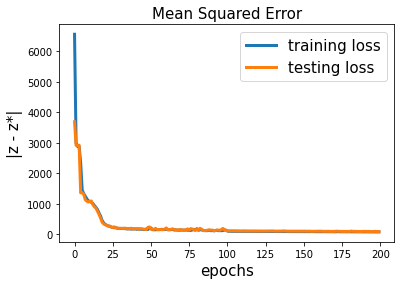

In [ ]:
# ---------------------------------------------
# Plot testing history
# ---------------------------------------------
import matplotlib.pyplot as plt

fig1 = plt.figure(1)
plt.plot(train_loss_hist, linewidth=3)
plt.plot(test_loss_hist, linewidth=3)
plt.legend(['training loss', 'testing loss'], fontsize=15)
plt.xlabel('epochs', fontsize=15)
plt.ylabel('|z - z*|', fontsize=15)
plt.title('Mean Squared Error', fontsize=15)
plt.savefig('line_plot.pdf')  

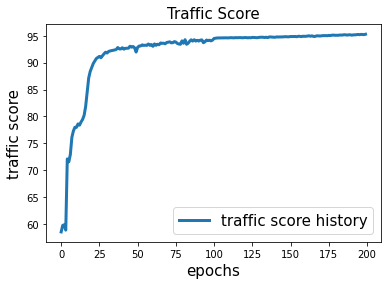

In [ ]:
fig1 = plt.figure(2)
plt.plot(traffix_score_hist, linewidth=3)
plt.legend(['traffic score history'], fontsize=15)
plt.xlabel('epochs', fontsize=15)
plt.ylabel('traffic score', fontsize=15)
plt.title('Traffic Score', fontsize=15)
plt.savefig('traffic_score_plot.pdf')  

## Generate CSV File

In [ ]:
filename = data_set + '_epoch_vs_relerr.csv'
with open(filename, 'w') as f: 
  for epoch, rel_err in enumerate(rel_err_hist):     
    f.write('%0.5e,%0.5e\n' % (epoch + 1, rel_err)) 

filename = data_set + '_epoch_vs_trafix.csv'
with open(filename, 'w') as f: 
  for epoch, traffix_score in enumerate(traffix_score_hist):     
    f.write('%0.5e,%0.5e\n' % (epoch + 1, traffix_score)) 